In [ ]:
import zipfile
import os
import pandas as pd

# Correct path in Colab
zip_path = "/content/heart+disease.zip"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/heart_disease")

    # List extracted files
    os.listdir("/content/heart_disease")


In [ ]:
import os
os.listdir("/content/heart_disease")


['processed.va.data',
 'reprocessed.hungarian.data',
 'processed.switzerland.data',
 'processed.cleveland.data',
 'switzerland.data',
 'ask-detrano',
 'bak',
 'new.data',
 'processed.hungarian.data',
 'long-beach-va.data',
 'heart-disease.names',
 'hungarian.data',
 'Index',
 'WARNING',
 'cleve.mod',
 'costs',
 'cleveland.data']

In [ ]:
df = pd.read_csv("/content/heart_disease/processed.cleveland.data", header=None)

df.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
columns = [
      "age", "sex", "cp", "trestbps", "chol", "fbs",
          "restecg", "thalach", "exang", "oldpeak", "slope",
              "ca", "thal", "target"
              ]

df.columns = columns
df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
import numpy as np
df=df.replace("?",np.nan)
for c in df.columns:
  df[c]=pd.to_numeric(df[c],errors="coerce")
df["target"]=(df["target"]>0).astype(int)
df.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

X=df.drop(columns=["target"])
y=df["target"]

num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal"]

numeric_tf = Pipeline(steps=[
      ("imputer", SimpleImputer(strategy="median"))
      ])

categorical_tf = Pipeline(steps=[
          ("imputer", SimpleImputer(strategy="most_frequent"))
          ])


preprocess = ColumnTransformer(
      transformers=[
              ("num", numeric_tf, num_cols),
                      ("cat", categorical_tf, cat_cols),
                          ],
                              remainder="drop"
                              )

X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
      )

dt_pipe = Pipeline(steps=[
      ("prep", preprocess),
          ("clf", DecisionTreeClassifier(random_state=42))
          ])




In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__criterion": ["gini","entropy","log_loss"],
        "clf__max_depth": [3,4,5,6,None],
            "clf__min_samples_split": [2,5,10],
                "clf__min_samples_leaf": [1,2,4],
                }

grid = GridSearchCV(
   dt_pipe,
   param_grid=param_grid,
   scoring="accuracy",
   cv=5,
   n_jobs=-1
   )

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best accuracy:", grid.best_score_)


Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
CV best accuracy: 0.7848639455782312


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Test accuracy: 0.7540983606557377

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.70      0.75        33
           1       0.70      0.82      0.75        28

    accuracy                           0.75        61
   macro avg       0.76      0.76      0.75        61
weighted avg       0.76      0.75      0.75        61


Confusion matrix:
 [[23 10]
 [ 5 23]]


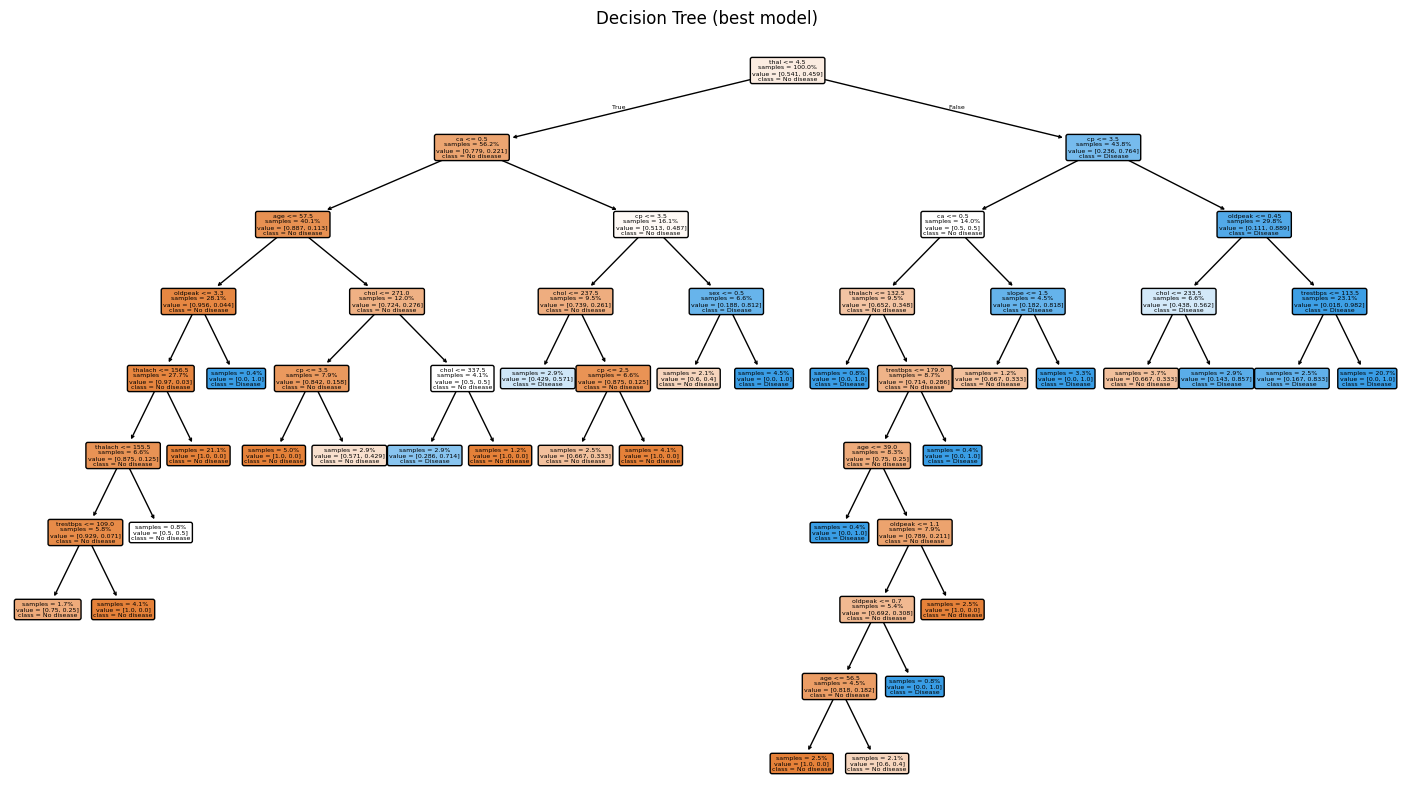

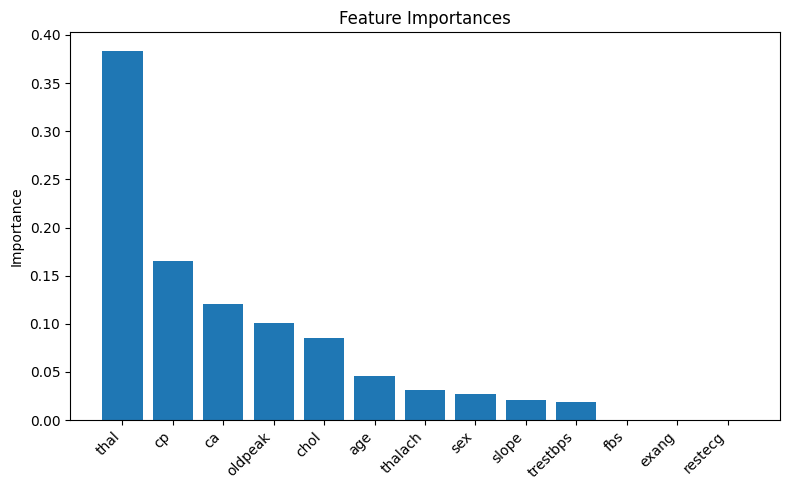

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np

# get the actual trained DecisionTreeClassifier from the pipeline
dt = best_model.named_steps["clf"]

# we need the transformed feature names after ColumnTransformer
num_feats = num_cols
cat_feats = cat_cols
feat_names = num_feats + cat_feats  # imputation keeps order

# plot the tree
plt.figure(figsize=(18,10))
tree.plot_tree(
    dt,
    feature_names=feat_names,
    class_names=["No disease","Disease"],
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True
   )
plt.title("Decision Tree (best model)")
plt.show()

                            # feature importances
importances = dt.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), np.array(feat_names)[order], rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

sample = {
    "age": 55, "sex": 1, "cp": 0, "trestbps": 130, "chol": 250, "fbs": 0,
        "restecg": 1, "thalach": 150, "exang": 0, "oldpeak": 1.0, "slope": 2,
            "ca": 0, "thal": 2
            }
x_new = pd.DataFrame([sample])[X.columns]  # same column order
pred = best_model.predict(x_new)[0]
proba = best_model.predict_prob`a(x_new)[0][1]
print("Prediction:", "Disease" if pred==1 else "No disease", "| Prob:", round(proba,3))


Prediction: No disease | Prob: 0.0
